## MAGIC Telescope analysis

##### Please view readme for a description of the project. If you are viewing this in Kaggle, click on the three dots next to "magic-gamma-telescope-dataset" under "datasets" in the right panel and select "Open in new tab" to view a detailed description of the data set and what this project entails. 
##### This notebook will be used to demonstrate analysis using both Python and SQL.
##### Attempting to use this notebook on other platforms will result in errors unless you move the data file and modify the next cells to contain the correct file path. 
##### This notebook was last updated 12/23/24.
##### To run this notebook, you may have to enter edit mode. 

In [1]:
# Import the packages we will use for analysis.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandasql as psql # using SQL in Python
import seaborn as sns # creating plots
import matplotlib.pyplot as plt # creating plots
from scipy import stats # statistical tests
from sklearn.decomposition import PCA # principal Component Analysis
from sklearn.preprocessing import StandardScaler # standardize the variables

# Certain features will be changing soon and will give us error messages when we run our cells, even though the operations are being done correctly.
# Let's disable that now before we proceed.

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/kaggle/input/magic-gamma-telescope-dataset/telescope_data.csv


## Data validity check

##### You should always check your data set to make sure it is clean and valid. This should be simple because the data set is already clean. 
##### Let's run just one test to see if there are any null values in the data set. 
##### We will do it in Python first, then SQL. There are several checks we can run with Python. 
##### Any of them would suffice but we will include 3 to demonstrate. 

In [2]:
# Step one of course is to mount our DataFrame! We will be using this DataFrame throughout the analysis. 
# Remember, this path will need to be changed if you are running this notebook in a different environment!

df = pd.read_csv('magic04.csv', header=0)

# The Kaggle dataset contains an unnamed column which numbers all observed data points. 
# We will remove it because it will confuse our calculations later on.

df = df.drop(df.columns[0], axis=1)

# Check for null values in each column.

null_counts = df.isnull().sum()
print("Null values in each column:")
print(null_counts)

# Check for null values in each row.

null_rows = df[df.isnull().any(axis=1)]
print("\nRows with any null values:")
print(null_rows)

# Check if there are any null values in the entire DataFrame.

has_nulls = df.isnull().values.any()
print("\nAre there any null values in the DataFrame?", has_nulls)

Null values in each column:
fLength     0
fWidth      0
fSize       0
fConc       0
fConc1      0
fAsym       0
fM3Long     0
fM3Trans    0
fAlpha      0
fDist       0
class       0
dtype: int64

Rows with any null values:
Empty DataFrame
Columns: [fLength, fWidth, fSize, fConc, fConc1, fAsym, fM3Long, fM3Trans, fAlpha, fDist, class]
Index: []

Are there any null values in the DataFrame? False


In [3]:
# Now let's run the check in SQL!
# We can use a join to test for all columns at once. 

null_conditions = ' OR '.join([f'"{col}" IS NULL' for col in df.columns])
query1 = f"""
SELECT *
FROM df
WHERE {null_conditions};
"""

# Execute the query.

result1 = psql.sqldf(query1, locals())

# Display the result.

print(result1)

Empty DataFrame
Columns: [fLength, fWidth, fSize, fConc, fConc1, fAsym, fM3Long, fM3Trans, fAlpha, fDist, class]
Index: []


## Finding ranges for variables
##### This will give us the chance to better understand the variables in our data set.
##### We will also be checking if the variables are continuous for the sake of the tests we will do and to help us spot any erroneous entries.
##### Finally, we will see if there is a difference in ranges for g and h class events. 

In [4]:
# We are going to use Python to see if the variables are continuous.
# It should show that all except 'class' are continuous. 
# We are basically just checking if the data type is numeric or not. 
# Continuous variables will allow us to run tests of significance between g and h class events later in our analysis. 

continuous_columns = df.select_dtypes(include=['int64', 'float64']).columns
continuity_result = pd.DataFrame({
    'column_name': df.columns,
    'continuity': ['Continuous' if col in continuous_columns else 'Not Continuous' for col in df.columns]
})

print(continuity_result)


   column_name      continuity
0      fLength      Continuous
1       fWidth      Continuous
2        fSize      Continuous
3        fConc      Continuous
4       fConc1      Continuous
5        fAsym      Continuous
6      fM3Long      Continuous
7     fM3Trans      Continuous
8       fAlpha      Continuous
9        fDist      Continuous
10       class  Not Continuous


In [5]:
# First we will use Python to determine the ranges of all variables. 
# This will work for all columns except "class" which is non-numeric and will be the basis of testing later on. 
# We can't find the range for that column so let's filter out only the numeric columns and then determine ranges. 

numeric_columns = df.select_dtypes(include=['number'])
range_values = numeric_columns.max() - numeric_columns.min()

# We will use a new DataFrame to arrange our ranges by column.

range_df = pd.DataFrame(range_values, columns=['Range'])

# Print the ranges.

print("Range for each numeric column:")
print(range_df)


Range for each numeric column:
              Range
fLength    329.8935
fWidth     256.3820
fSize        3.3820
fConc        0.8799
fConc1       0.6749
fAsym     1033.1568
fM3Long    570.1010
fM3Trans   385.7457
fAlpha      90.0000
fDist      494.2784


In [6]:
# Let's do the same thing in SQL. 
# We will need to tell it to get the range for each column one at a time. 

# Write query. 

query2 = """
SELECT 
    MAX(fLength) - MIN(fLength) AS range_fLength,
    MAX(fWidth) - MIN(fWidth) AS range_fWidth,
    MAX(fSize) - MIN(fSize) AS range_fSize,
    MAX(fConc) - MIN(fConc) AS range_fConc,
    MAX(fConc1) - MIN(fConc1) AS range_fConc1,
    MAx(fAsym) - MIN(fAsym) AS range_fAsym,
    MAX(fM3Long) - MIN(fM3Long) AS range_fM3Long,
    MAX(fM3Trans) - MIN(fM3Trans) AS range_fM3Trans,
    MAX(fAlpha) - MIN(fAlpha) AS range_fAlpha,
    MAX(fDist) - MIN(fDist) AS range_fDist
FROM df;
"""
# Run Query and display results.

result2 = psql.sqldf(query2, locals())
print(result2)

   range_fLength  range_fWidth  range_fSize  range_fConc  range_fConc1  \
0       329.8935       256.382        3.382       0.8799        0.6749   

   range_fAsym  range_fM3Long  range_fM3Trans  range_fAlpha  range_fDist  
0    1033.1568        570.101        385.7457          90.0     494.2784  


In [7]:
# Group by 'class' and calculate the min and max for all other columns.

range_stats = df.groupby('class').agg([min, max])

print(range_stats)

       fLength          fWidth            fSize           fConc          \
           min      max    min      max     min     max     min     max   
class                                                                     
g      12.1929  272.063    0.0  176.335  1.9978  5.0100  0.0139  0.8889   
h       4.2835  334.177    0.0  256.382  1.9413  5.3233  0.0131  0.8930   

       fConc1             fAsym            fM3Long           fM3Trans  \
          min     max       min       max      min      max       min   
class                                                                   
g      0.0073  0.6752 -349.7570  219.8960 -198.867  215.894  -91.3485   
h      0.0003  0.6430 -457.9161  575.2407 -331.780  238.321 -205.8947   

                fAlpha         fDist           
           max     min   max     min      max  
class                                          
g      101.393  0.0000  90.0  5.7456  450.402  
h      179.851  0.0097  90.0  1.2826  495.561  


In [8]:
# To do the same thing in SQL, we will add a group by statement to our previous query.

query3 = """
SELECT 
    class,
    MAX(fLength) - MIN(fLength) AS range_fLength,
    MAX(fWidth) - MIN(fWidth) AS range_fWidth,
    MAX(fSize) - MIN(fSize) AS range_fSize,
    MAX(fConc) - MIN(fConc) AS range_fConc,
    MAX(fConc1) - MIN(fConc1) AS range_fConc1,
    MAX(fAsym) - MIN(fAsym) AS range_fAsym,
    MAX(fM3Long) - MIN(fM3Long) AS range_fM3Long,
    MAX(fM3Trans) - MIN(fM3Trans) AS range_fM3Trans,
    MAX(fAlpha) - MIN(fAlpha) AS range_fAlpha,
    MAX(fDist) - MIN(fDist) AS range_fDist
FROM df
GROUP BY class;
"""

# Run the query and display results.

result3 = psql.sqldf(query3, locals())
print(result3)


  class  range_fLength  range_fWidth  range_fSize  range_fConc  range_fConc1  \
0     g       259.8701       176.335       3.0122       0.8750        0.6679   
1     h       329.8935       256.382       3.3820       0.8799        0.6427   

   range_fAsym  range_fM3Long  range_fM3Trans  range_fAlpha  range_fDist  
0     569.6530        414.761        192.7415       90.0000     444.6564  
1    1033.1568        570.101        385.7457       89.9903     494.2784  


##### Based on these calcuations, it appears that the h ranges are wider than the g ranges and they fully encompass them. 
##### This makes sense because h class events are the 'noise' or all inputs detected by the telescope and g class events are the 'signal' or gamma rays from hadronic showers that the telescope is designed to detect. 
##### This is a good start. It means our telescope is collecting the right data. 

## Finding averages between g and h class events for all variables

##### Now, we need to find the means of g (signal) and h (noise) events across all of the data collection variables. 
##### This will prepare us to determine if there is a significant difference between these measurements and ultimately conclude that our telescope is working properly and providing us with valuable scientific information. 
##### We should observe a large difference in means on some observation measures and a very small difference on others. 

In [9]:
# Python can do this in just a few lines. 

average_stats = df.groupby('class').mean()

average_stats_filtered = average_stats.loc[['g', 'h']]

print(average_stats_filtered)

         fLength     fWidth     fSize     fConc    fConc1      fAsym  \
class                                                                  
g      43.654539  18.592698  2.784021  0.383641  0.215048   3.236653   
h      70.943504  28.797373  2.900609  0.374217  0.213937 -18.287111   

         fM3Long  fM3Trans     fAlpha       fDist  
class                                              
g      17.809413  0.190873  18.784309  190.229712  
h      -2.848298  0.358245  43.985233  200.434517  


In [10]:
# SQL can also accomplish this quickly! 

query4 = """
SELECT 
    class,
    AVG(fLength) AS avg_fLength,
    AVG(fWidth) AS avg_fWidth,
    AVG(fSize) AS avg_fSize,
    AVG(fConc) AS avg_fConc,
    AVG(fConc1) AS avg_fConc1,
    AVG(fAsym) AS avg_fAsym,
    AVG(fM3Long) AS avg_fM3Long,
    AVG(fM3Trans) AS avg_fM3Trans,
    AVG(fAlpha) AS avg_fAlpha,
    AVG(fDist) AS avg_fDist
FROM df
WHERE class IN ('g', 'h')
GROUP BY class;
"""

# Run the query and display results.

average_inSQL = psql.sqldf(query4, locals())
print(average_inSQL)


  class  avg_fLength  avg_fWidth  avg_fSize  avg_fConc  avg_fConc1  avg_fAsym  \
0     g    43.654539   18.592698   2.784021   0.383641    0.215048   3.236653   
1     h    70.943504   28.797373   2.900609   0.374217    0.213937 -18.287111   

   avg_fM3Long  avg_fM3Trans  avg_fAlpha   avg_fDist  
0    17.809413      0.190873   18.784309  190.229712  
1    -2.848298      0.358245   43.985233  200.434517  


##### Right away, we can see some of these variables have a large difference between g and h class events.
##### This is to be expected because gamma readings will occur in a specific range.
##### Later on, we will test the significance of these differences in means and determine exactly which variables allow us to differentiate g and h class events. 

## Correlation functions

##### We can run tests to determine if any two of our observation variables are correlated. 
##### The closer the correlation coeficient is to 1 or -1, the stronger the correlation is between two variables. 
##### A correlation coeficient of 0 indicates no correlation.
##### A positive correlation coeficient indicates that as the first variable increases, the other variable increases. 
##### A negative correlation coeficient indicates that as the first variable increases, the other variable decreases. 

In [11]:
# Python lets us carry out a correlation function in a few lines. 
# The first step is to select only numerical columns. Class is not a numerical column and won't serve any purpose in the correlation function.
# Please note that Pandasql uses SQLite syntax, which does not support the CORR function directly, so we can only demonstrate this in Python.

numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix.

correlation_matrix = np.corrcoef(numeric_df.T)

# Create a DataFrame for better readability.

correlation_df = pd.DataFrame(correlation_matrix, index=numeric_df.columns, columns=numeric_df.columns)

print(correlation_df)

           fLength    fWidth     fSize     fConc    fConc1     fAsym  \
fLength   1.000000  0.770512  0.702454 -0.630999 -0.598145 -0.368556   
fWidth    0.770512  1.000000  0.717517 -0.609779 -0.581141 -0.266961   
fSize     0.702454  0.717517  1.000000 -0.850850 -0.808835 -0.159863   
fConc    -0.630999 -0.609779 -0.850850  1.000000  0.976412  0.112272   
fConc1   -0.598145 -0.581141 -0.808835  0.976412  1.000000  0.100159   
fAsym    -0.368556 -0.266961 -0.159863  0.112272  0.100159  1.000000   
fM3Long  -0.119747 -0.176234  0.095157 -0.121899 -0.118769  0.274045   
fM3Trans  0.013389  0.039744  0.015455 -0.011294 -0.010966  0.002553   
fAlpha   -0.008777  0.066061 -0.186675  0.235272  0.229799 -0.055689   
fDist     0.418466  0.336816  0.437041 -0.328332 -0.304625 -0.206730   

           fM3Long  fM3Trans    fAlpha     fDist  
fLength  -0.119747  0.013389 -0.008777  0.418466  
fWidth   -0.176234  0.039744  0.066061  0.336816  
fSize     0.095157  0.015455 -0.186675  0.437041  
fCo

##### The strongest correlation we have observed is between fConc and fConc1.
##### fLength, fWidth, and fSize are all somewhat correlated. fSize correlates with fConc and fConc1. 
##### No other variables strongly correlate. 


In [12]:
# For good measure, let's see how the correlation coefficients look when separated for g and h class events. 
# We will need to make a separate DataFrame for g and h class correlation coeficients.
# We will start with g.

g_df = df[df['class'] == 'g'].select_dtypes(include=[np.number])
correlation_g = np.corrcoef(g_df.T)

correlation_g_df = pd.DataFrame(correlation_g, index=g_df.columns, columns=g_df.columns)

# Calculate correlations for h class events. 

h_df = df[df['class'] == 'h'].select_dtypes(include=[np.number])
correlation_h = np.corrcoef(h_df.T)

correlation_h_df = pd.DataFrame(correlation_h, index=h_df.columns, columns=h_df.columns)

# Print and compare outputs.

print("Correlation Matrix for class 'g':")
print(correlation_g_df)
print("\nCorrelation Matrix for class 'h':")
print(correlation_h_df)

Correlation Matrix for class 'g':
           fLength    fWidth     fSize     fConc    fConc1     fAsym  \
fLength   1.000000  0.695646  0.766119 -0.710201 -0.679977 -0.120237   
fWidth    0.695646  1.000000  0.855156 -0.761339 -0.731427 -0.002603   
fSize     0.766119  0.855156  1.000000 -0.863438 -0.825388  0.029023   
fConc    -0.710201 -0.761339 -0.863438  1.000000  0.979331 -0.033395   
fConc1   -0.679977 -0.731427 -0.825388  0.979331  1.000000 -0.037631   
fAsym    -0.120237 -0.002603  0.029023 -0.033395 -0.037631  1.000000   
fM3Long   0.542494  0.422040  0.540958 -0.452183 -0.433914  0.162438   
fM3Trans  0.012365  0.044029  0.022637 -0.017358 -0.016044 -0.005629   
fAlpha   -0.443254 -0.296896 -0.458027  0.482306  0.463505 -0.004521   
fDist     0.602484  0.389203  0.459633 -0.368563 -0.347069 -0.178247   

           fM3Long  fM3Trans    fAlpha     fDist  
fLength   0.542494  0.012365 -0.443254  0.602484  
fWidth    0.422040  0.044029 -0.296896  0.389203  
fSize     0.540958  

##### We have several strongly correlated features. fConc and fConc1 are the most correlated at over 97%.
##### Since g class events are observed in a certain range, our correlations with fSize and fConc/fConc1 seem a bit stronger than for h class events. 
##### The correlations between fLength, fWidth, fSize, fConc, and fConc1 with fAsym are stronger for h class events. 
##### fAlpha correlates much more with measurement variables in g class events. In h class events, the correlation coeficients are near zero. 
##### fAsym has higher correlation coeficients for several variables in h class events. 

## T-tests

##### Earlier, we calculated means in g and h class events. We need to determine if the differences between them are statistically significant. 
##### This will tell us which measures determine the difference between signal and noise in our telescope data. 
##### As always, we start with the null hypothesis that there is no siginificant difference. We will use a 5% confidence interval. 

In [13]:
# As with the correlation functions, this can only be demonstrated in python due to syntax limitations. 

# Define the variables of interest and use them to create g_values and h_values DataFrames. 

variables = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']

g_values = df[df['class'] == 'g'][variables].to_numpy()
h_values = df[df['class'] == 'h'][variables].to_numpy()

# Create empty DataFrame to store results - it will be appended with the next functions. 

t_test_results = []

# Perform t-tests for each variable.

for i, column in enumerate(variables):
  
    t_stat, p_value = stats.ttest_ind(g_values[:, i], h_values[:, i], equal_var=False)  # Welch's t-test
    
# Including means in the resul for your conveninece. This demonstrates another way to calculate mean.
    
    g_mean = np.mean(g_values[:, i])
    h_mean = np.mean(h_values[:, i])
    
# Interpret results
    
    interpret = 'Reject' if p_value < .05 else 'Not reject'
    
# Store results in the t_test_results DataFrame.

    t_test_results.append({
        'Variable': column,
        'g mean': g_mean,
        'h mean': h_mean,
        't-statistic': t_stat,
        'p-value': p_value,
        'Result' : interpret
    })

# Create a final DataFrame for readability. 

t_test_df = pd.DataFrame(t_test_results)

# Print the results.

print(t_test_df)

   Variable      g mean      h mean  t-statistic        p-value      Result
0   fLength   43.654539   70.943504   -36.540832  5.814357e-271      Reject
1    fWidth   18.592698   28.797373   -29.811710  1.185878e-184      Reject
2     fSize    2.784021    2.900609   -16.179144   2.550780e-58      Reject
3     fConc    0.383641    0.374217     3.323823   8.903991e-04      Reject
4    fConc1    0.215048    0.213937     0.641201   5.214038e-01  Not reject
5     fAsym    3.236653  -18.287111    20.158216   2.724465e-88      Reject
6   fM3Long   17.809413   -2.848298    22.532621  3.290839e-109      Reject
7  fM3Trans    0.190873    0.358245    -0.433999   6.643006e-01  Not reject
8    fAlpha   18.784309   43.985233   -67.746679   0.000000e+00      Reject
9     fDist  190.229712  200.434517    -8.615441   7.830556e-18      Reject


## Visualizations

##### Now it is time to create some visualizations of our data.

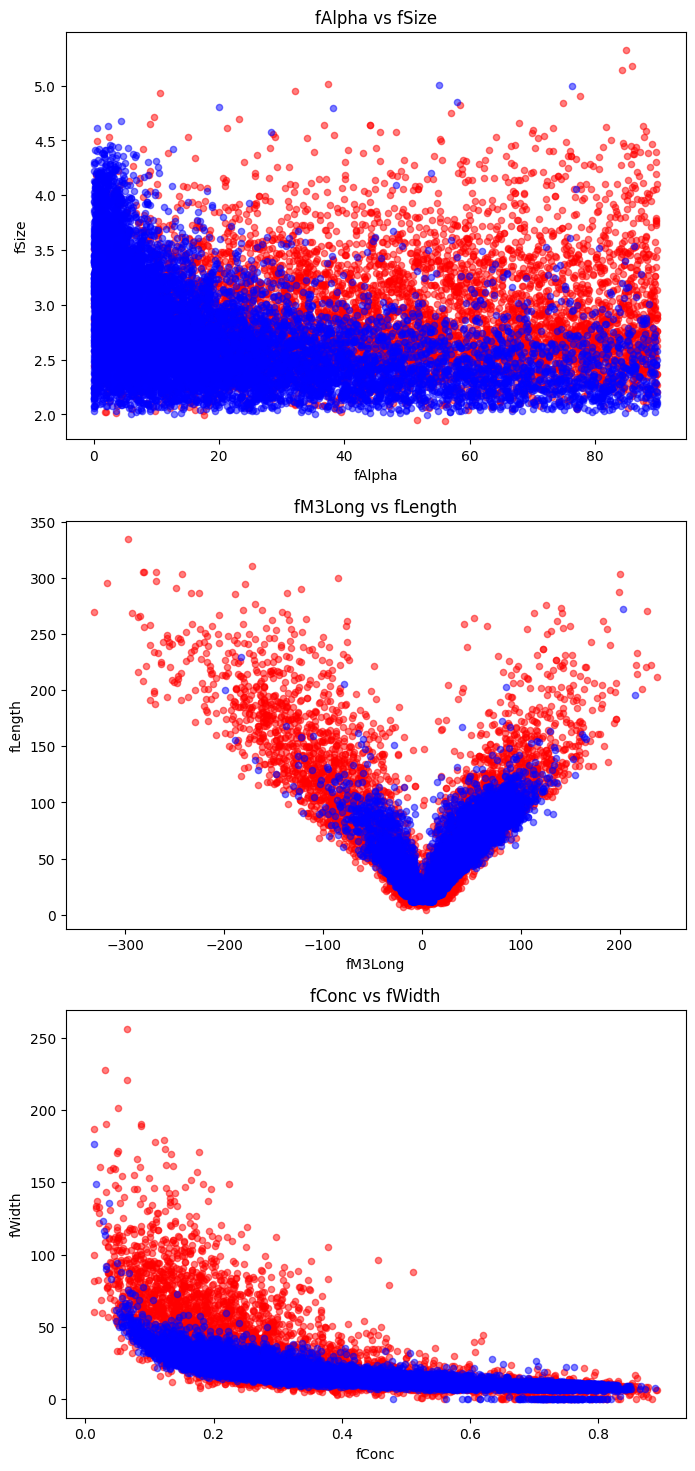

In [14]:
# Let's start with some scatterplots showing two of our variables with a different color for g and h class events. 
# We will now use those plotting packages that we imported at the beginning of this notebook! 

# Start by setting the dimensions of our plots so they will be arranged in an intuitive way. 

fig, axs = plt.subplots(3, figsize=(8, 18))

# Pair 1

df[df['class'] == 'h'].plot.scatter(x='fAlpha', y='fSize', ax=axs[0], color='red', alpha=0.5)
df[df['class'] == 'g'].plot.scatter(x='fAlpha', y='fSize', ax=axs[0], color='blue', alpha=0.5)
axs[0].set_title('fAlpha vs fSize')

# Pair2

df[df['class'] == 'h'].plot.scatter(x='fM3Long', y='fLength', ax=axs[1], color='red', alpha=0.5)
df[df['class'] == 'g'].plot.scatter(x='fM3Long', y='fLength', ax=axs[1], color='blue', alpha=0.5)
axs[1].set_title('fM3Long vs fLength')

# Pair 3

df[df['class'] == 'h'].plot.scatter(x='fConc', y='fWidth', ax=axs[2], color='red', alpha=0.5)
df[df['class'] == 'g'].plot.scatter(x='fConc', y='fWidth', ax=axs[2], color='blue', alpha=0.5)
axs[2].set_title('fConc vs fWidth')

plt.show()

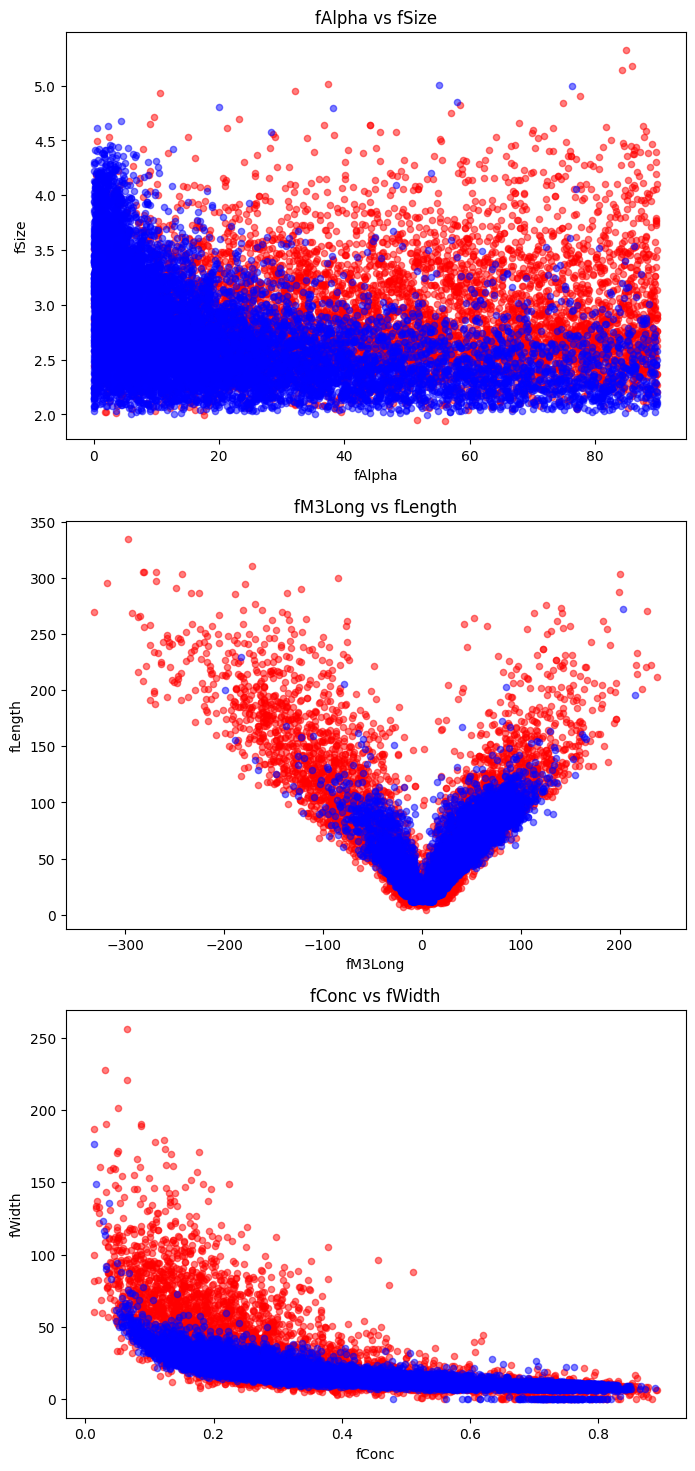

In [15]:
# If we want to achieve this in SQL, we are still limited by our syntax, but we can use SQL to arrange data for us. 

# Create a new DataFrame using SQL to select the data we want to use for our plot.

sql_df = psql.sqldf("SELECT fAlpha, fSize, fWidth, fM3Long, fLength, fConc, fM3Trans, class FROM df ORDER BY class DESC")

# Create the same 2 column arrangement.

fig, axs = plt.subplots(3, figsize=(8, 18))

# Create the same three scatterplot sets. 

sql_df[sql_df['class'] == 'h'].plot.scatter(x='fAlpha', y='fSize', ax=axs[0], color='red', alpha=0.5)
sql_df[sql_df['class'] == 'g'].plot.scatter(x='fAlpha', y='fSize', ax=axs[0], color='blue', alpha=0.5)
axs[0].set_title('fAlpha vs fSize')

sql_df[sql_df['class'] == 'h'].plot.scatter(x='fM3Long', y='fLength', ax=axs[1], color='red', alpha=0.5)
sql_df[sql_df['class'] == 'g'].plot.scatter(x='fM3Long', y='fLength', ax=axs[1], color='blue', alpha=0.5)
axs[1].set_title('fM3Long vs fLength')

sql_df[sql_df['class'] == 'h'].plot.scatter(x='fConc', y='fWidth', ax=axs[2], color='red', alpha=0.5)
sql_df[sql_df['class'] == 'g'].plot.scatter(x='fConc', y='fWidth', ax=axs[2], color='blue', alpha=0.5)
axs[2].set_title('fConc vs fWidth')

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

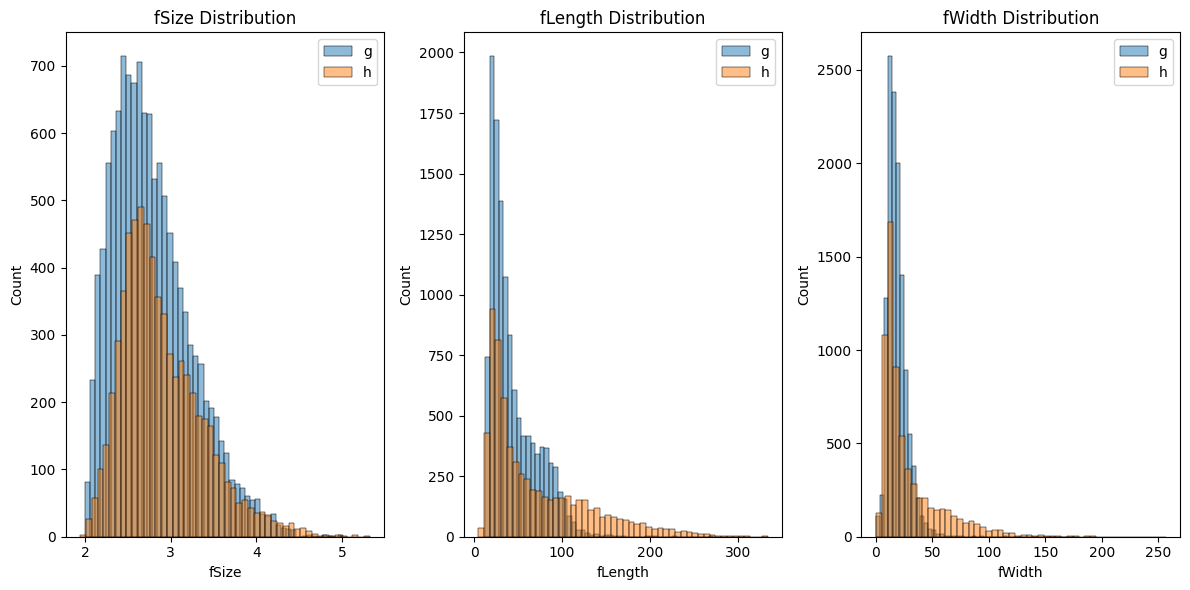

In [16]:
# You can probably already see that the majority of g class events fall within specific ranges within our variables while h class events have a wider
# distribution, reflecting all of the 'noise' signals the telescope is recieving. 

# Now, let's create some histograms for g and h class events using the fSize fLength and fWidth variables. 
# We will use the seaborn package to demonstrate different packages for creating plots in Python. 

# We will get an error message if we don't replace infinite values with NaN.

df = df.replace([np.inf, -np.inf], np.nan)

# Set the colums for the plots as we did before.

plt.figure(figsize=(12,6))

# Create our plots.
# Note that we are setting alpha at 0.5 to create transparency so one column color does not completely obscure the other.
# We will divide results into 50 bins to create a smoother chart.

plt.subplot(1, 3, 1)
sns.histplot(df[df['class'] == 'g']['fSize'], label='g', alpha=0.5, bins=50)
sns.histplot(df[df['class'] == 'h']['fSize'], label='h', alpha=0.5, bins=50)
plt.legend()
plt.title('fSize Distribution')

plt.subplot(1, 3, 2)
sns.histplot(df[df['class'] == 'g']['fLength'], label='g', alpha=0.5, bins=50)
sns.histplot(df[df['class'] == 'h']['fLength'], label='h', alpha=0.5, bins=50)
plt.legend()
plt.title('fLength Distribution')

plt.subplot(1, 3, 3)
sns.histplot(df[df['class'] == 'g']['fWidth'], label='g', alpha=0.5, bins=50)
sns.histplot(df[df['class'] == 'h']['fWidth'], label='h', alpha=0.5, bins=50)
plt.legend()
plt.title('fWidth Distribution')

plt.tight_layout()
plt.show

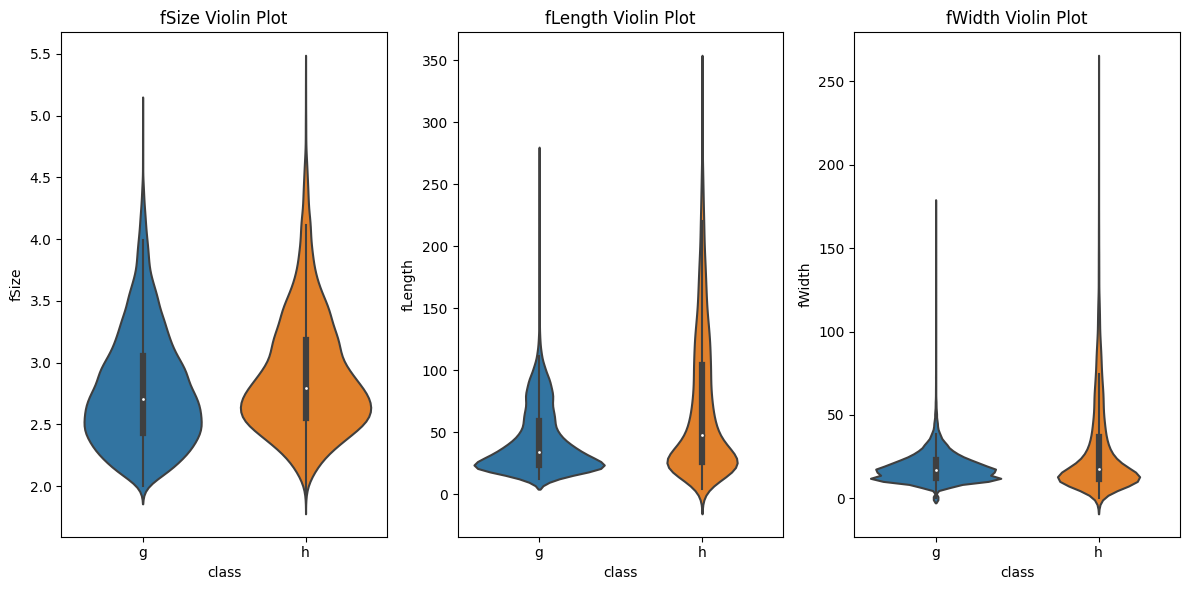

In [17]:
# We can use a violin plot to visualize the same three variables. 
# This gives us a different 'picture' of the underlying distribution.

# Set plot dimensions once more.

plt.figure(figsize=(12, 6))

# Create three plots.

plt.subplot(1, 3, 1)
sns.violinplot(x='class', y='fSize', data=df)
plt.title('fSize Violin Plot')

plt.subplot(1, 3, 2)
sns.violinplot(x='class', y='fLength', data=df)
plt.title('fLength Violin Plot')

plt.subplot(1, 3, 3)
sns.violinplot(x='class', y='fWidth', data=df)
plt.title('fWidth Violin Plot')
plt.tight_layout()
plt.show()

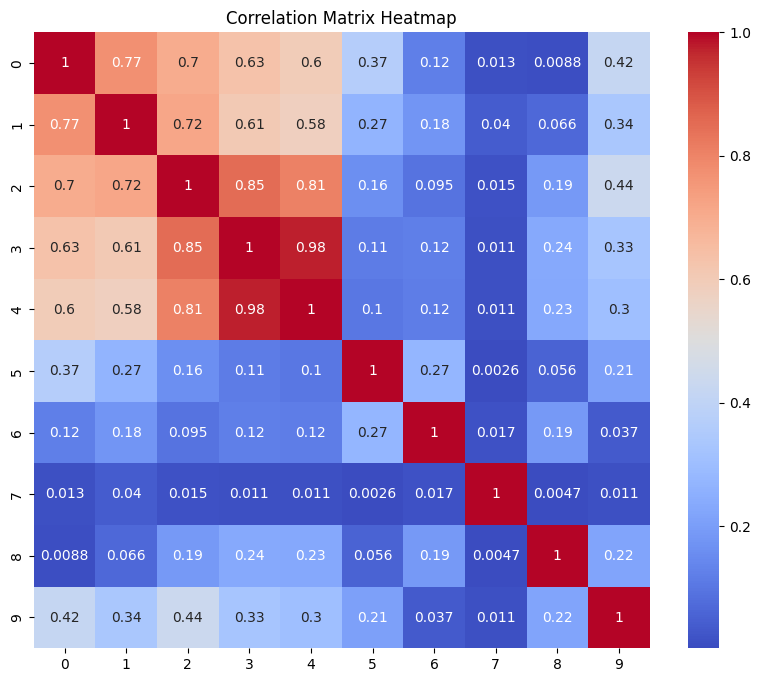

In [18]:
# For our final visualization, we will create a correlation heatmap for ALL variables in g and h class events!
# We created a correlation matrix earlier.
# Here is what it looks like visualized before separating by class.
# We will be using absolute values of the correlation coeficients since we are only interested in the strength of the correlation. 

plt.figure(figsize=(10, 8))
sns.heatmap(abs(correlation_matrix), annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

## Principal Component Analysis

##### Principal Component Analysis (PCA) is a way to simplify a data set to its most important parts.
##### It transforms correlated variables into new linear variables (called components) to illustrate multidimensional correlation.
##### It is one of the basic techniques of machine learning!
##### We will use this to show many variances on a single plot to highlight the difference between g and h class events.

In [19]:
# Select the numeric columns from the DataFrame.

numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Standardize the variables.

X = StandardScaler().fit_transform(numeric_df.values) 

# Create a PCA object with desired number of components (e.g., 2 for 2D visualization):

pca = PCA(n_components=2)

# Fit the PCA model to the numeric data and transform it into principal components:

principal_components = pca.fit_transform(X)

# Create a new dataframe with the principal components:

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Add the class labels back to the PCA dataframe.

pca_df['class'] = df['class']

In [20]:
# How much of the information is summed in the PCA?

pca.explained_variance_ratio_ 

# Our figure repesents roughly 58% (the sum of both the values in the following array)

array([0.42239909, 0.15751879])

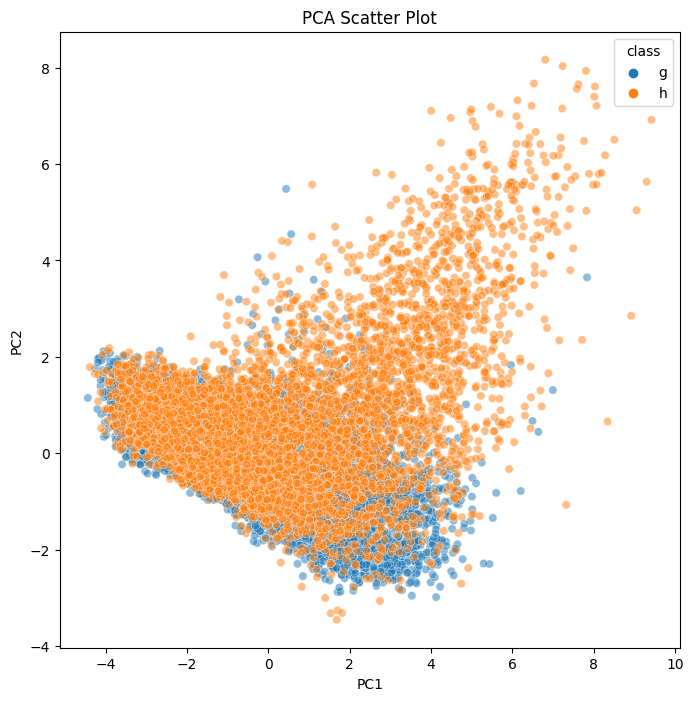

In [21]:
# Now we can create a scatterplot of the principal components.
# Each point represents a data sample and the axes represent the principal components.

plt.figure(figsize=(8, 8))
sns.scatterplot(x='PC1', y='PC2', hue='class', alpha=0.5, data=pca_df)
plt.title('PCA Scatter Plot')
plt.show()

##### Great! From this plot, we can see tha most of the g class events are in one range, while many h class (noise) events skew upward and outward along the axes. 
##### We can consider the g class events outside of the main area to be outliers.
##### There are far more h class events outside of this area of the plot. 
##### This matches our expectaion for the results since g class events represent a specific detection from the telescope.

## Conclusion

##### First and foremost, every step of our analysis indicates that the MAGIC telescope is working correctly. 
##### The variables of measurement are useful in distinguishing the gamma particles we are trying to detect from the
##### totality of all information recieved by the telescope. 
#####
##### Using both SQL and Python, we determined that the variable ranges of h class events contain the ranges of g class events.
##### This was our first indication that there is a distinct difference between the signal and the noise detections. 
#####
##### As predicted, we determined that the means of g and h class events were quite different for some variables and much narrower
##### for other variables. 
##### Notably, the absolute value of the mean **fAsym** is far greater in h class events. **fAsym** is the distance from the highest pixel to
##### the center. This also confirms that gamma events occur within a range that is fully encompassed by all telescope observations. 
##### Another major difference in means was measured in **fM3Long**, which measures the 3rd root of third moment along major axis.
##### This is another indicator that g class events are observed within specific parameters by the MAGIC telescope.
#####
##### We were also able to create a correlaion matrix to determine which variables are closely correlated. 
##### We found that **fConc** and **fConc 1** are the most strongly correlated. This was no surprise because they are both similar measurements.
##### **fConc** is the ratio of the sum of the two highest pixels over **fSize**, and **fConc1** is the ratio of just the highest pixel over **fSize.**
##### We also investigated the correlations within g and h class events and found some interesting results. 
##### g class events showed a stronger correlation with **fSize** and the **fConc** variabes because they are detected in a narrower range.
##### h class events showed a stronger correlation between **fAsym** and several variables. 
##### This is to be expected because h class events occur across a broader range, and as mentioned, have a much greater average distance. 
##### As we stated in the correlation section, **fAlpha** correlates more with measurement variables in g class events. 
##### In h class (noise) events, there is very little correlation. This is more evidence that the telescope is giving us valuable and accurate data. 
#####
##### Next came t-tests, which determined the statistical significance of differences in means of all variables. 
##### Only 2 variables (**fConc1** and **fM3trans**) accepted the null hypothesis that there was no significant difference. 
##### Therefore, we can make comparisons between all other variables to differentiate between g and h class events. 
##### We used some of these variables to create visualizations in the next section of the analysis. 
#####
##### With our scatterplots, we demonstrated how both SQL and Python can be employed to visualize the ranges of both event classes by different pairs of variables. 
##### As expected, the plots show g class events observed within a specific range and h class events more widely and randomly distributed. 
##### The same can also be said for our histograms, which show the distributions of single variables across both classes, revealing the same patterns. 
##### As always, the distributions of h class events includes and overlaps the distribution of g class events. 
##### Next, the violin plots show the distribution shape of different variables, revealing noticable differences between g and h class observations. 
##### Finally, for good measure, we created a visualization of our correlation matrix which is color coded to highlight the strongest correlations between variables. 
#####
##### Last but not least, we performed a principal component analysis (PCA) to demonstrate a machine learning technique in Python. 
##### This allows us to aggregate all of the data onto a two axis plot. 
##### The result is a plot that factors in all of the variables across both classes.
##### As always, we can see a distinct range for gamma observation and a wider and more random distribution for hadron observations. 
#####
##### None of our observations went against our expectations or indicated any problems with our telescope system. 
##### We hope that the MAGIC telescope will continue to inform scientific study for many years to come!
##### Thank you for joining us on our exploration of this valuable and fascinating data set. 
##### We hope that it can teach something about the various programming languages and analysis techniques that we use in the world of data science!
##### 
![MAGIC Telescope in action!](http://www.miguelclaro.com/wp/wp-content/uploads/2013/10/MAGIC-LaPalma_4829-net-900x600.jpg)